In [1]:
import numpy as np
import tensorflow as tf
print('tf: %s' % tf.__version__)
import tarfile
import cv2
from matplotlib import pyplot as plt
import scipy
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
print('keras: %s' % keras.__version__)

tf: 2.0.0
keras: 2.2.4-tf


In [2]:
# we will crop and resize input images to IMG_SIZE x IMG_SIZE
IMG_SIZE = 150

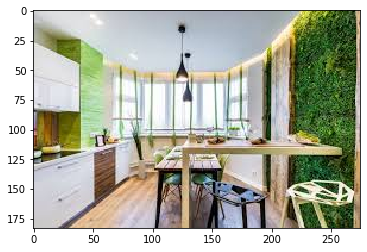

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


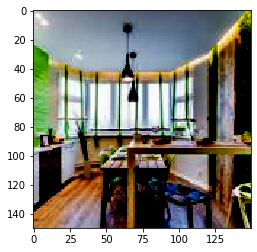

In [3]:
def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def image_center_crop(img):
    """
    Makes a square center crop of an img, which is a [h, w, 3] numpy array.
    Returns [min(h, w), min(h, w), 3] output with same width and height.
    For cropping use numpy slicing.
    """

    h, w, c = img.shape
    side = min(h, w)
    if h >= w: 
        cropped_img = img[(h-side)//2:(h-side)//2+side,:,:]
    else:
        cropped_img = img[:,(w-side)//2:(w-side)//2+side,:]
        
    
    # checks for errors    
    assert cropped_img.shape == (min(h, w), min(h, w), c), "error in image_center_crop!"
    
    return cropped_img

def prepare_raw_bytes_for_model(raw_bytes, normalize_for_model=True):
    img = decode_image_from_raw_bytes(raw_bytes)  # decode image raw bytes to matrix
    img = image_center_crop(img)  # take squared center crop
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # resize for our model
    if normalize_for_model:
        img = img.astype("float32")  # prepare for normalization
        img = keras.applications.inception_v3.preprocess_input(img)  # normalize for model
    return img

# reads bytes directly from tar by filename (slow, but ok for testing, takes ~6 sec)
def read_raw_from_tar(tar_fn, fn):
    with tarfile.open(tar_fn) as f:
        m = f.getmember(fn)
        return f.extractfile(m).read()
    
# test cropping
raw_bytes = read_raw_from_tar("interior.tar.gz", "eco/local-filename0.jpg")

img = decode_image_from_raw_bytes(raw_bytes)
plt.imshow(img)
plt.show()

img = prepare_raw_bytes_for_model(raw_bytes, normalize_for_model=True)
plt.imshow(img)
plt.show()

In [33]:
# read filenames firectly from tar
def get_all_filenames(tar_fn):
    with tarfile.open(tar_fn) as f:
        return [m.name for m in f.getmembers() if m.isfile()]

fnames = get_all_filenames('interior.tar.gz')

label_names = [fname.split('/')[0] for fname in fnames]
N_CLASSES = len(np.unique(label_names))
label_dict = dict(zip(np.unique(label_names), list(range(len(np.unique(label_names))))))
labels = [label_dict[name] for name in label_names]

In [34]:
indices = [i for i in range(len(fnames))]
np.random.shuffle(indices)

In [35]:
fnames = np.take(fnames, indices)
labels = np.take(labels, indices)

In [37]:
tr_files, te_files, tr_labels, te_labels = train_test_split(fnames, labels, test_size=0.2, stratify=labels)

In [38]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, tar_fn, list_IDs, labels, dim=(150, 150), n_channels=3, batch_size=32, n_classes=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.n_channels = n_channels
        self.fn = tar_fn
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_classes = n_classes
        self.shuffle = shuffle    
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        while True:
            for batch in self.__batch_generator(self.__yield_raw(self.fn, self.list_IDs, self.labels), self.batch_size):
                # prepare batch images
                batch_imgs = []
                batch_targets = []
                for raw, label in batch:
                    img = prepare_raw_bytes_for_model(raw)
                    batch_imgs.append(img)
                    batch_targets.append(label)
                # stack images into 4D tensor [batch_size, img_size, img_size, 3]
                batch_imgs = np.stack(batch_imgs, axis=0)
                # convert targets into 2D tensor [batch_size, num_classes]

                batch_targets = keras.utils.to_categorical(batch_targets, N_CLASSES)
                yield batch_imgs, batch_targets   
    
    def __yield_raw(self, tar_fn, files, labels):
        'will yield raw image bytes from tar with corresponding label'
        label_by_fn = dict(zip(files, labels))
        with tarfile.open(tar_fn) as f:
            while True:
                m = f.next()
                if m is None:
                    break
                if m.name in label_by_fn:
                    yield f.extractfile(m).read(), label_by_fn[m.name]
                    
    def __batch_generator(self, items, batch_size):
        batch = []
        for ix, item in enumerate(items):
            #import pdb; pdb.set_trace();
            batch.append(item)
            if (ix + 1) % batch_size == 0:
                yield batch
                batch = []

        yield batch

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

In [39]:
BATCH_SIZE = 4

# Parameters
params = {'dim': (250, 250),
          'batch_size': BATCH_SIZE,
          'n_channels': 3,
          'n_classes': 102,
          'shuffle': True}

train_generator = next(iter(DataGenerator('interior.tar.gz', tr_files, tr_labels, **params)))
test_generator = next(iter(DataGenerator('interior.tar.gz', te_files, te_labels, **params)))

In [40]:
def inception(use_imagenet=True):
    # load pre-trained model graph, don't add final layer
    model = keras.applications.InceptionV3(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                          weights='imagenet' if use_imagenet else None)
    # add global pooling just like in InceptionV3
    new_output = keras.layers.GlobalAveragePooling2D()(model.output)
    # add new dense layer for our labels
    new_output = keras.layers.Dense(N_CLASSES, activation='softmax')(new_output)
    model = keras.Model(model.inputs, new_output)
        
    return model

model = inception()

In [41]:
# set all layers trainable by default
for layer in model.layers:
    layer.trainable = True
    #if isinstance(layer, keras.layers.BatchNormalization):
    if isinstance(layer, type(model.layers[2])):
        # we do aggressive exponential smoothing of batch norm
        # parameters to faster adjust to our new dataset
        layer.momentum = 0.9
    
# fix deep layers (fine-tuning only last 50)
for layer in model.layers[:-50]:
    # fix all but batch norm layers, because we neeed to update moving averages for a new dataset!
    #if not isinstance(layer, keras.layers.BatchNormalization):
    if not isinstance(layer, type(model.layers[2])):
        layer.trainable = False

In [42]:
# compile new model
model.compile(
    loss='categorical_crossentropy',  # we train 102-way classification
    optimizer=keras.optimizers.Adamax(lr=1e-3),  # we can take big lr here because we fixed first layers
    metrics=['accuracy']  # report accuracy during training
)

In [ ]:
# fine tune for 2 epochs (full passes through all training data)
# we make 2*8 epochs, where epoch is 1/8 of our training data to see progress more often
model.fit_generator(
    generator=train_generator,
    steps_per_epoch=len(tr_files) // BATCH_SIZE // 8,
    validation_data=test_generator,
    validation_steps=len(te_files) // BATCH_SIZE // 4,
    epochs=2*8
)

Epoch 1/16
108/108 [==============================] - 37s 341ms/step - loss: 0.6448 - accuracy: 0.8958 - val_loss: 2.1177 - val_accuracy: 0.5602
Epoch 2/16
108/108 [==============================] - 37s 339ms/step - loss: 0.1344 - accuracy: 0.9583 - val_loss: 11.4016 - val_accuracy: 0.0000e+00
Epoch 3/16
 85/108 [======================>.......] - ETA: 6s - loss: 1.3030 - accuracy: 0.7941